### Node Embeddings


In [1]:
%pip install -q python-dotenv networkx pyvis node2vec gensim scikit-learn numpy pandas matplotlib seaborn nodevectors python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
load_dotenv()


True

### Node2Vec algorithm

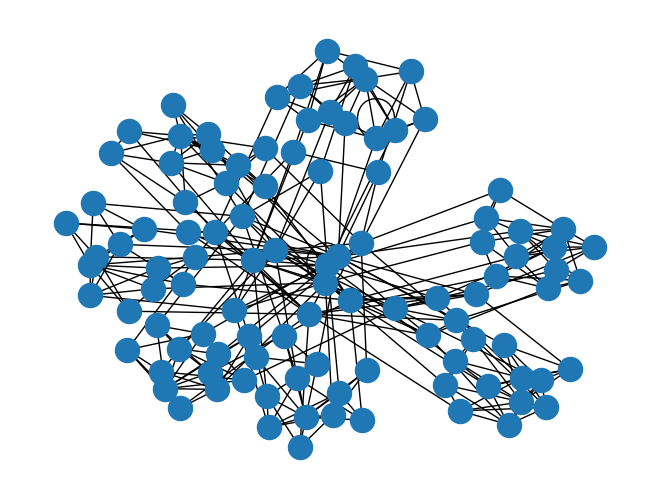

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.read_graphml('data/graph.graphml')
nx.draw(G)
plt.show()


#### Graph Embeddings
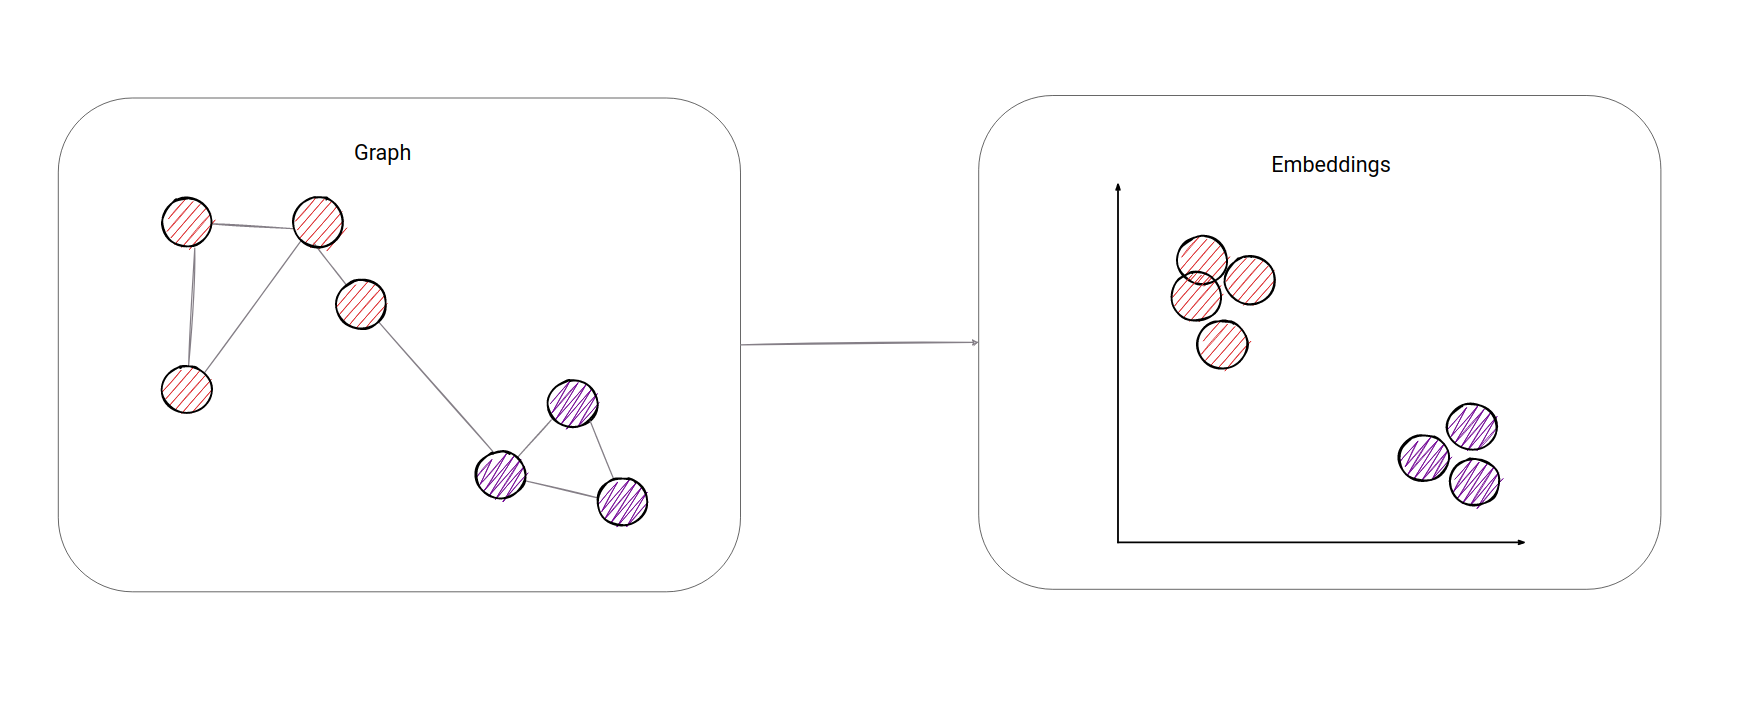

Graph embedding: This refers to the process of transforming a graph into a continuous vector space, where each node (or edge) in the graph is represented as a low-dimensional vector, preserving the graph's structure and relationships.


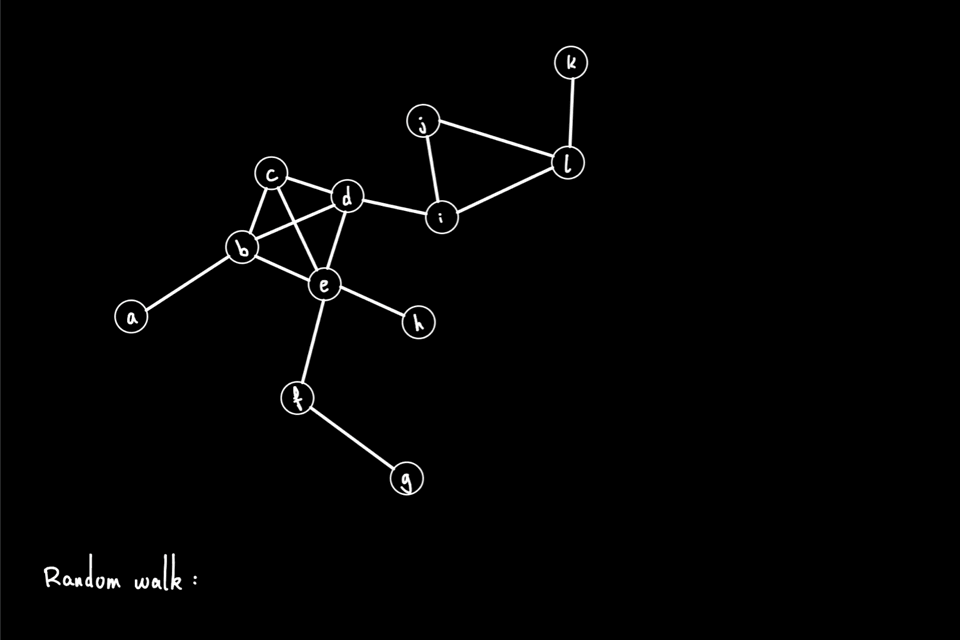
Random walks on graph embeddings is a technique for navigating a graph probabilistically and using the walks to learn meaningful low-dimensional representations of the nodes in the graph. These representations preserve the structure of the graph and are useful in downstream tasks such as node classification, link prediction, and community detection.

In [4]:
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=20, walk_length=10, num_walks=100, workers=2)


/Users/pedropacheco/Projects/demos/graphrag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 736.59it/s]


In [5]:
model = node2vec.fit(window=10, min_count=1)


#### Most similar nodes

In [6]:
for node, _ in model.wv.most_similar('real_madrid'):
    print(node)


toni_kroos
sergio_ramos
pepe
karim_benzema
james_rodriguez
luka_modric
marcelo
cristiano_ronaldo
gareth_bale
carvajal


In [7]:
for node, _ in model.wv.most_similar('paulo_dybala'):
    print(node)


juan_cuadrado
gonzalo_higuain
mario_mandzukic
juventus
miralem_pjanic
sami_khedira
stephan_lichtsteiner
alex_sandro
giorgio_chiellini
leonardo_bonucci


#### Persistance

In [8]:
node_data = [
    {
        'id': node, 
        'type': attributes.get('type', None), 
        '$vector': model.wv[str(node)]
    }
    for node, attributes in G.nodes(data=True)
]


In [11]:
import os
from astrapy import DataAPIClient
from astrapy.constants import VectorMetric

# Initialize the client and get a "Database" object
client = DataAPIClient(os.environ["ASTRA_DB_APPLICATION_TOKEN"])
database = client.get_database(os.environ["ASTRA_DB_API_ENDPOINT"])

print(f"* Database: {database.info().name}\n")

# Create a vector-enabled collection
collection = database.create_collection(
    "node_embeddings", 
    namespace="node_embedding",
    dimension=20, 
    metric=VectorMetric.COSINE,  # Or just 'cosine'
    check_exists=False  # Optional
)
print(f"* Collection: {collection.full_name}\n")


* Database: graphrag

* Collection: node_embedding.node_embeddings



In [13]:
collection.delete_many({})
insertion_result = collection.insert_many(node_data)
print(f"* Inserted {len(insertion_result.inserted_ids)} items.\n")


* Inserted 104 items.



In [22]:
real_madrid = rm = next((item for item in node_data if item.get('id') == 'st'), None)
for node in collection.find({}, sort={"$vector": real_madrid['$vector']}, limit=11):
    print (node)


{'_id': '69157420-71a2-4038-9574-2071a2e0384e', 'id': 'st', 'type': None}
{'_id': 'b8dd3f91-cf0f-4f77-9d3f-91cf0faf7758', 'id': 'zlatan_ibrahimovic', 'type': 'Player'}
{'_id': 'cd6f7bf1-1ae1-4212-af7b-f11ae1b21277', 'id': 'gonzalo_higuain', 'type': 'Player'}
{'_id': '131c0eb9-ec2d-491c-9c0e-b9ec2d691c8a', 'id': 'cam', 'type': None}
{'_id': 'f3493ea9-4dcd-4e5f-893e-a94dcd2e5fc3', 'id': 'henrikh_mkhitaryan', 'type': 'Player'}
{'_id': '7a23b010-3694-4440-a3b0-10369424401d', 'id': 'anthony_martial', 'type': 'Player'}
{'_id': '84c9dde5-7bd8-4f87-89dd-e57bd83f8710', 'id': 'lorenzo_insigne', 'type': 'Player'}
{'_id': '2dd47f16-e213-41e6-947f-16e21311e6b2', 'id': 'karim_benzema', 'type': 'Player'}
{'_id': '0021c9c5-12de-4f55-a1c9-c512de0f5502', 'id': 'lw', 'type': None}
{'_id': '702a70e2-62cc-4948-aa70-e262ccb94810', 'id': 'dries_mertens', 'type': 'Player'}
{'_id': '42b9c0ed-d440-40c3-b9c0-edd44020c3d0', 'id': 'leroy_sane', 'type': 'Player'}


#### Visualization

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)


In [ ]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato'
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]


In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);
